## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d
from scipy.stats import norm

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

import diptest

import pickle

## Data

In [2]:
# with open('/workspaces/human_hippocampus/dev/other/thomas/thesis/pickled_datasets/random_dataset.pkl', 'rb') as file:
#     sd = pickle.load(file)

# with open('data/linear_overlap_spike_data.pkl', 'rb') as file:
#     sd2 = pickle.load(file)


# with open('data/linear_overlap_spike_data.pkl', 'rb') as file:
#     sd = pickle.load(file)

with open('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl', "rb") as my_file:
    sd = pickle.load(my_file)



# with open('/workspaces/human_hippocampus/data/processed/ephys/2023-12-03-e-Hc112823_avv9hckcr1/curated_base_acqm.pkl', 'rb') as file:
#     sd = pickle.load(file)

## Helper Functions

In [3]:

def local_safe_divide(numerator, denominator):
    """Safely divide two numbers, returning 0 when the denominator is 0."""
    return numerator / denominator if denominator != 0 else 0

def local_sttc_ta(tA, delt, tmax):
    '''
    Helper function for spike time tiling coefficients: calculate the
    total amount of time within a range delt of spikes within the
    given sorted list of spike times tA.
    '''
    if len(tA) == 0:
        return 0

    base = min(delt, tA[0]) + min(delt, tmax - tA[-1])
    return base + np.minimum(np.diff(tA), 2 * delt).sum()

def local_sttc_na(tA, tB, delt):
    '''
    Helper function for spike time tiling coefficients: given two
    sorted lists of spike times, calculate the number of spikes in
    spike train A within delt of any spike in spike train B.
    '''
    if len(tB) == 0:
        return 0
    tA, tB = np.asarray(tA), np.asarray(tB)

    # Find the closest spike in B after spikes in A.
    iB = np.searchsorted(tB, tA, side='right')
    iB = np.clip(iB, 1, len(tB) - 1)

    dt_left = np.abs(tB[iB - 1] - tA)
    dt_right = np.abs(tA - tB[np.clip(iB, 0, len(tB) - 1)])

    # Return how many of those spikes are actually within delt.
    return np.sum(np.minimum(dt_left, dt_right) <= delt)

def local_spike_time_tiling(tA, tB, TA, TB, delt):
    """
    Internal helper method for the second half of STTC calculation.
    """
    PA = local_safe_divide(local_sttc_na(tA, tB, delt), len(tA))
    PB = local_safe_divide(local_sttc_na(tB, tA, delt), len(tB))

    aa = local_safe_divide((PA - TB), (1 - PA * TB))
    bb = local_safe_divide((PB - TA), (1 - PB * TA))
    return (aa + bb) / 2

def local_spike_time_tiling_coefficient(tA, tB, delt=20, length=None):
    """
    Calculate the spike time tiling coefficient between two spike trains.
    """
    if length is None:
        length = max(tA[-1], tB[-1]) if tA and tB else 0

    if len(tA) == 0 or len(tB) == 0:
        return 0.0

    TA = local_safe_divide(local_sttc_ta(tA, delt, length), length)
    TB = local_safe_divide(local_sttc_ta(tB, delt, length), length)
    return local_spike_time_tiling(tA, tB, TA, TB, delt)

class LocalSpikeData:
    def __init__(self, train, length, neuron_data):
        self.train = train
        self.length = length
        self.N = len(train)
        self.neuron_data = neuron_data

    def local_spike_time_tilings(self, delt=20):
        """
        Compute the full spike time tiling coefficient matrix.
        """
        T = self.length
        ts = [local_safe_divide(local_sttc_ta(ts, delt, T), T) for ts in self.train]

        ret = np.diag(np.ones(self.N))
        for i in range(self.N):
            for j in range(i + 1, self.N):
                ret[i, j] = ret[j, i] = local_spike_time_tiling(
                    self.train[i], self.train[j], ts[i], ts[j], delt
                )
        return ret

In [4]:
def latencies_between_two_neurons(train_a, train_b, window_ms=100):
    '''
    Compute latencies between the spike trains of two neurons.
    
    :param train_a: Spike train of the first neuron (numpy array).
    :param train_b: Spike train of the second neuron (numpy array).
    :param window_ms: Window in milliseconds to consider for latency calculation.
    :return: List of lists, where each sublist contains latencies from each spike in train_a
             to spikes in train_b within the specified window.
    '''
    latencies = []
    
    # Check if either of the trains is empty
    if len(train_a) == 0 or len(train_b) == 0:
        return latencies
    
    for spike_a in train_a:
        # Calculate differences between spike_a and all spikes in train_b
        diffs = train_b - spike_a
        # Filter the differences to find those within the specified window
        relevant_latencies = diffs[np.abs(diffs) <= window_ms]
        
        if len(relevant_latencies) > 0:
            latencies.append(relevant_latencies.tolist())
            
    return latencies

In [ ]:
# latencies = latencies_between_two_neurons(sd.spike_data[0], sd.spike_data[1], window_ms=500)

In [5]:
sd = LocalSpikeData(sd.train, sd.length, sd.neuron_data)

/tmp/ipykernel_20369/2622252714.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sd = LocalSpikeData(sd.train, sd.length, sd.neuron_data)


In [6]:
dT = 40 # delta t for spike time tilings in ms
MIN_SPIKES = 5
N = sd.N
STTC_THRESH = 0.1
MEAN_THRESH = 0.5
PVAL_THRESH = 0.1
FWHM_THRESH = 30

tile_coefficients_whole = np.zeros((N, N))
mean_latencies = np.nan * np.zeros((N, N))
pvals_per_edge = np.nan * np.zeros((N, N))
fwhm_per_edge = np.nan * np.zeros((N, N))

# sttc_values = sd.local_spike_time_tilings(delt=dT)
sttc_values = sd.local_spike_time_tilings(delt=dT)

for ref_channel in range(N):
    for comp_channel in range(N):
        if ref_channel == comp_channel:
            continue
        ref_train = sd.train[ref_channel]
        comp_train = sd.train[comp_channel]
        
        # Ensure both channels have a minimum number of spikes
        if len(ref_train) > MIN_SPIKES and len(comp_train) > MIN_SPIKES:
            sttc_value = sttc_values[ref_channel, comp_channel]

            if sttc_value > STTC_THRESH:
                # print(sttc_value)
                # Extract latencies
                latencies = latencies_between_two_neurons(ref_train, comp_train, window_ms=dT)

                # Remove latencies larger than dT
                latencies = [lat for sublist in latencies for lat in sublist if np.abs(lat) <= dT]

                if np.abs(np.mean(latencies)) > 0:
                    # print(np.mean(latencies))
                    
                    pdf = np.sort(latencies)

                    # Compute the dip test
                    dip, p_val = diptest.diptest(pdf)

                    if p_val > PVAL_THRESH:
                        print(p_val)
                        pd_mean = np.mean(pdf)
                        pd_std = np.std(pdf)
                        pd_fwhm = 2 * np.sqrt(2 * np.log(2)) * pd_std

                        if pd_fwhm < FWHM_THRESH:
                            print("YES")
                            mean_latencies[comp_channel, ref_channel] = pd_mean
                            pvals_per_edge[comp_channel, ref_channel] = p_val
                            fwhm_per_edge[comp_channel, ref_channel] = pd_fwhm

                            # Adjust storage based on mean latency direction
                            if np.abs(mean_latencies[comp_channel, ref_channel]) > MEAN_THRESH:
                                tile_coefficients_whole[comp_channel, ref_channel] = sttc_value

0.8426401050010706
0.855107636116857
0.9825326404657617
0.6016604751985226
0.5023522323465353
0.7355695696673871
0.29448119708456155
0.6612501825122605
0.43085610053571066
0.33994466770020315
0.5878375111464009
0.43193687161282446
0.5689885111541353
0.9919551904147953
0.9832616930790108
0.13220660296058406
0.9460231047304052
0.8426401050010701
0.48277594888618547
0.3487921865656286
0.9680005529956405
0.5356660278429635
0.9026532622712219
0.9872285793451508
0.9787017751157336
0.33450373425750257
0.505647311187113
0.8185457335997566
0.855107636116857
0.2675188775751717
0.12517249148561227
0.8205234135936419
0.7833201305151622
0.6805868007396989
0.7206279731820888
0.4715487966959536
0.4454565507137771
0.4401055705484419
0.6693247264182367
0.4681694668161617
0.7942464473984278
0.11510651890029311
0.7797145859160477
0.9645057361013187
0.9509133378654875
0.9911628987286308
0.7846253767108783
0.9825326404657617
0.482775948886186
0.5056473111871127
0.2675188775751711
0.5183905211703954
0.49824

In [7]:
# Print full tile coefficients - all of them
for i in range(len(tile_coefficients_whole)):
    for j in range(len(tile_coefficients_whole[i])):
        if tile_coefficients_whole[i][j] > 0:
            print(f"From {i} to {j}: {tile_coefficients_whole[i][j]}")

From 17 to 66: 0.2381351579443692
From 41 to 66: 0.2320620747228733
From 66 to 17: 0.2381351579443692
From 66 to 41: 0.2320620747228733


In [8]:
sd_neuron_data_formatted = {'positions': {}}

for cluster_id, cluster_data in sd.neuron_data.items():
    for channel_id, channel_data in cluster_data.items():
        position = channel_data['position']
        sd_neuron_data_formatted['positions'][channel_id] = {'position': position}

In [9]:
sd_new = SpikeData(sd.train, neuron_data=sd_neuron_data_formatted)

In [10]:
sd = sd_new

In [11]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        if (in_out_deg[i][1] + in_out_deg[i][0]) == 0:
            test1 = 0
            test2 = 0
        else:
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        
        if test1 > latency_thresh:
            node_info[i] = 'red'
        elif test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info

def plot_functional_connectivity_map( sd, latency_threshold=.1, show_sttc=True,  sttc_threshold=.011):
    """
    Output: plots the functional connectivity map, displayin "sender" and ""receiver" neurons in the neural circuit
    Inputs:
        sd (SpikeData object)- the standard data format for braingeneers
        latency_threshold (float)- Between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
        show_sttc (boolean)- If True, the spike time tiling connections between neurons are also plotted
        sttc_threshold (float)- Between 0-1. The strength a spike time tiling correlation must be above in order to be plotted
    """
    # Plot functional connectivity map
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold )
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in sd.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(8,8))
    plt.scatter(neuron_x, neuron_y, c=sender_receiver_neurons)
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.gca().add_artist(node_type_legend)
    plt.title("Functional Connectivity Map - Random Data")
    plt.xlabel('X position')
    plt.ylabel('Y position')

    # Plot spike time tiling connections between neurons
    if show_sttc:
        sttc = tile_coefficients_whole
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue
                if sttc[i,j] < sttc_threshold : continue
                ix,iy = sd.neuron_data['positions'][i]['position']
                jx,jy = sd.neuron_data['positions'][j]['position']
                # ix,iy = sd.neuron_data[0][i]['position']
                # jx,jy = sd.neuron_data[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                # Plot line between the points with linewidth and opacity
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        plt.gca().add_artist(correlation_legend)
    
    # Invert y axis to match the image
    plt.gca().invert_yaxis()

    # Make x and y axis equal
    plt.axis('equal')

    plt.show()

calculating all latencies...
making plot


/tmp/ipykernel_20369/3285206896.py:102: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data['positions'].values():
/tmp/ipykernel_20369/3285206896.py:126: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  ix,iy = sd.neuron_data['positions'][i]['position']
/tmp/ipykernel_20369/3285206896.py:127: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  jx,jy = sd.neuron_data['positions'][j]['position']


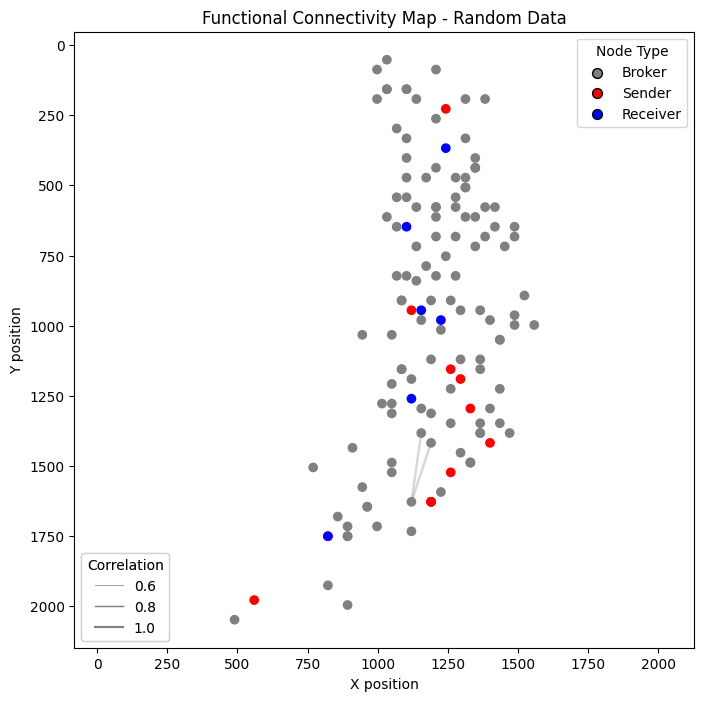

In [13]:
plot_functional_connectivity_map(sd, latency_threshold=.2, show_sttc=True,  sttc_threshold=.1)

In [59]:
n5_n19_latencies = latencies_between_two_neurons(sd.train[5], sd.train[19])

In [64]:
latencies = [lat for sublist in n5_n19_latencies for lat in sublist if np.abs(lat) <= 50]

In [67]:
sorted = np.sort(latencies)

In [68]:
diptest.diptest(sorted)

(0.034863417942450924, 0.3060378489794009)

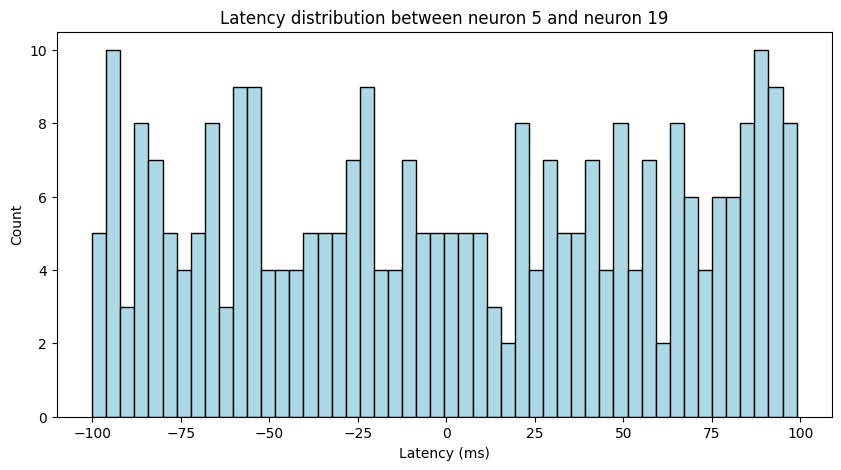

In [58]:
# Plot the latency distribution for neuron 5 and neuron 19
plt.figure(figsize=(10, 5))
plt.hist([lat for sublist in n5_n19_latencies for lat in sublist], bins=50, color='lightblue', edgecolor='black')
plt.title('Latency distribution between neuron 5 and neuron 19')
plt.xlabel('Latency (ms)')
plt.ylabel('Count')
plt.show()

In [53]:
n1_n11_latencies = latencies_between_two_neurons(sd.train[1], sd.train[11])

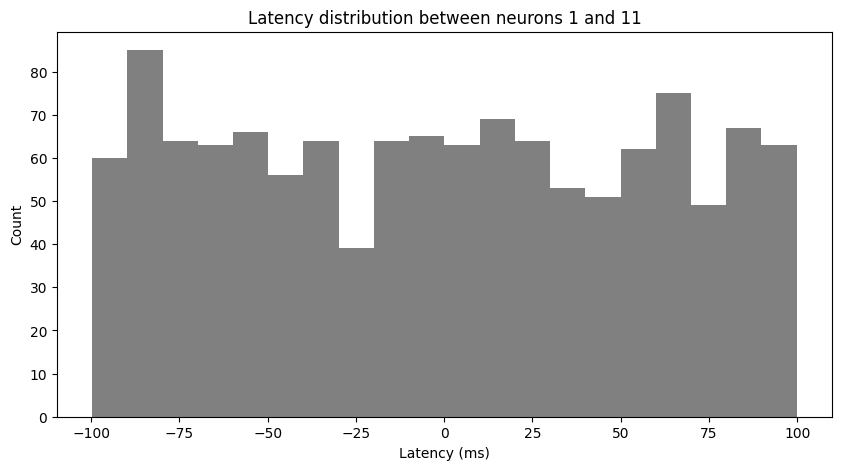

In [54]:
# Plot latency distribution n1 n11
plt.figure(figsize=(10, 5))
plt.hist([lat for sublist in n1_n11_latencies for lat in sublist], bins=20, color='gray')
plt.xlabel('Latency (ms)')
plt.ylabel('Count')
plt.title('Latency distribution between neurons 1 and 11')
plt.show()

In [50]:
n11_n1_latencies = latencies_between_two_neurons(sd.train[11], sd.train[1])

In [51]:
len(n11_n1_latencies)

1110

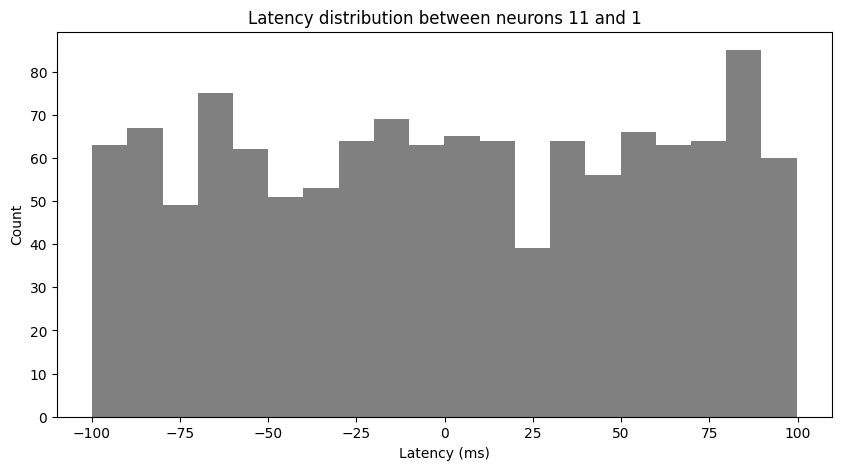

In [55]:
# Plot latency distribution n11 n1
plt.figure(figsize=(10, 5))
plt.hist([lat for sublist in n11_n1_latencies for lat in sublist], bins=20, color='gray')
plt.xlabel('Latency (ms)')
plt.ylabel('Count')
plt.title('Latency distribution between neurons 11 and 1')
plt.show()

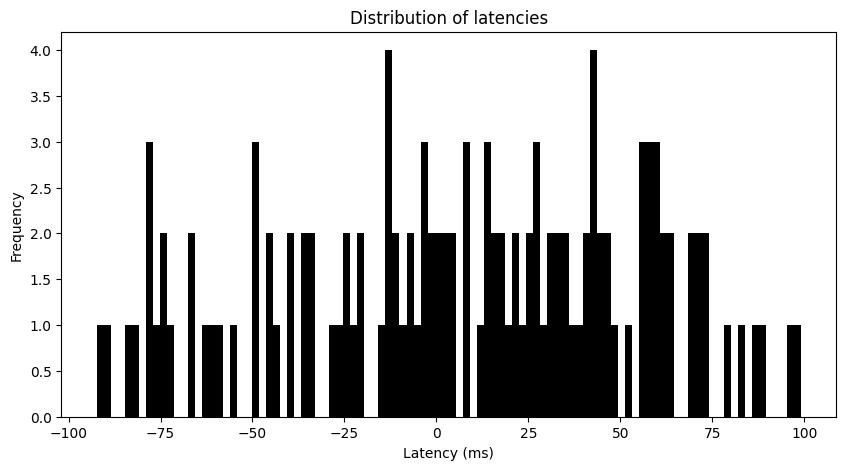

In [43]:
# Plot distribution of latencies
latencies = sd.latencies_to_index(16)[0]
latencies = np.array(latencies)
# Plot distribution of latencies
plt.figure(figsize=(10, 5))
plt.hist(latencies, bins=100, color='black')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('Distribution of latencies')
plt.show()

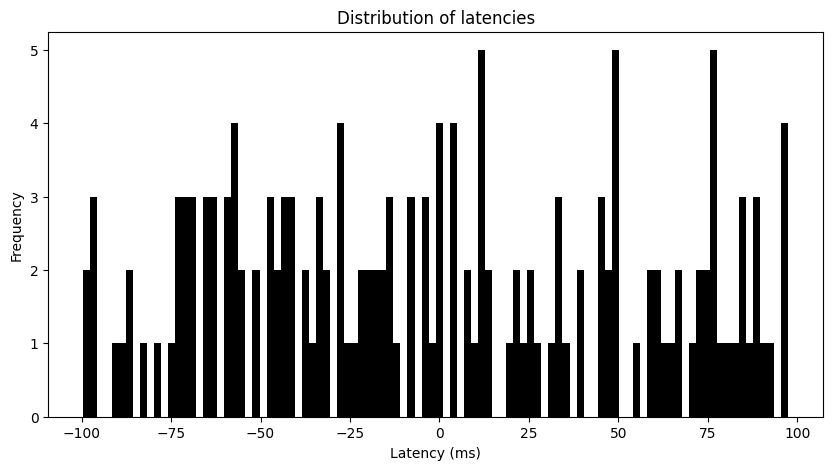

In [44]:
# Plot distribution of latencies
latencies = sd.latencies_to_index(0)[16]
latencies = np.array(latencies)
# Plot distribution of latencies
plt.figure(figsize=(10, 5))
plt.hist(latencies, bins=100, color='black')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('Distribution of latencies')
plt.show()

## Functional Connectivity Map Code

In [12]:
# Constants
dT = 1000
MIN_SPIKES = 5
MIN_COEF_THRESH = 0.1
MEAN_THRESH = 2
PVAL_THRESH = 0.1
FWHM_THRESH = 15
NBOOT = 500
DIRECTIONAL = True

In [13]:
# Initialize result matrices
N = sd.N
tile_coefficients_whole = np.nan * np.zeros((N, N))
mean_latencies = np.nan * np.zeros((N, N))
pvals_per_edge = np.nan * np.zeros((N, N))
fwhm_per_edge = np.nan * np.zeros((N, N))

In [14]:
def extract_latencies(ref_spike_times, comp_spike_times):
    # Initialize empty list to store results
    latencies = []

    # Iterate through each spike time in the reference list
    for ref_time_idx, ref_time in enumerate(ref_spike_times):
        
        # Find the spike in the comparison list that lies closest to the current reference spike
        time_differences = np.abs(comp_spike_times - ref_time)
        min_diff = np.min(time_differences)
        closest_comp = comp_spike_times[np.where(time_differences == min_diff)[0][0]]
        
        # Calculate the time difference
        time_diff = closest_comp - ref_time

        # If the time difference is positive
        if time_diff > 0:
            # Check if the next reference spike is closer than the closest comparison spike
            if ref_time_idx == len(ref_spike_times) - 1 or ref_spike_times[ref_time_idx + 1] - ref_time > time_diff:
                # Store the result
                latencies.append(time_diff)
        
        # If the time difference is negative
        elif time_diff < 0:
            # Check if the previous reference spike is closer than the closest comparison spike
            if ref_time_idx == 0 or ref_spike_times[ref_time_idx - 1] - ref_time < time_diff:
                # Store the result
                latencies.append(time_diff)
                
    return np.array(latencies)

In [15]:
def HartigansDipSignifTest(data):
    # Calculate dip statistic
    dip, p_value = diptest.diptest(data)
    
    return dip, p_value

In [16]:
sttc_values = sd.spike_time_tilings(delt=dT)

for ref_channel in range(N):
    for comp_channel in range(N):
        if comp_channel == ref_channel:
            continue
        # Get the spike times for the reference and comparison channels
        ref_spikes = sd.train[ref_channel]
        comp_spikes = sd.train[comp_channel]

        # Ensure both channels have a minimum number of spikes
        if len(ref_spikes) >= MIN_SPIKES and len(comp_spikes) >= MIN_SPIKES:
            # Calculate STTC
            sttc_val = sttc_values[ref_channel, comp_channel]
            # print("Ref, Comp, STTC: ", ref_channel, comp_channel, sttc_val)

            if sttc_val > MIN_COEF_THRESH:
                # Extract latencies
                latencies = extract_latencies(ref_spikes, comp_spikes)

                # Remove latencies larger than dT
                latencies = latencies[np.abs(latencies) < dT]

                if np.abs(np.mean(latencies)) > MEAN_THRESH:
                    
                    pdf = np.sort(latencies)
                    # Perform Hartigan's dip test for multimodality
                    dip, p_value = HartigansDipSignifTest(pdf)

                    if p_value > PVAL_THRESH:
                        print("YES")
                        # Compute FWHM assuming normal distribution of latencies
                        pd_mean, pd_std = norm.fit(latencies)
                        fwhm = 2 * np.sqrt(2 * np.log(2)) * pd_std

                        if fwhm < FWHM_THRESH:
                            print("YES2")
                            # Store results
                            mean_latencies[comp_channel, ref_channel] = np.mean(latencies)
                            pvals_per_edge[comp_channel, ref_channel] = p_value
                            fwhm_per_edge[comp_channel, ref_channel] = fwhm

                            if DIRECTIONAL:
                                # Adjust storage basen on mean latency direction
                                if mean_latencies[comp_channel, ref_channel] > MEAN_THRESH:
                                    tile_coefficients_whole[comp_channel, ref_channel] = sttc_val
                                elif mean_latencies[comp_channel, ref_channel] < -MEAN_THRESH:
                                    tile_coefficients_whole[comp_channel, ref_channel] = sttc_val
                            else:
                                if np.abs(mean_latencies[comp_channel, ref_channel]) > MEAN_THRESH:
                                    tile_coefficients_whole[comp_channel, ref_channel] = sttc_val



YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
YES
YES2
Y

In [17]:
# number non nan
np.sum(~np.isnan(tile_coefficients_whole))

28160

## Plotting

In [19]:
tile_coefficients_whole.shape

(256, 256)

In [7]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def latencies_mean_neuron(lat_list):
    """
    Output: Returns a list containing the mean latencies for each sublist.
    Input: lat_list- A list of lists representing latencies between a particular neuron, x, and all others. Created with `sd.latencies_to_index(x)`
    """
    nested_list = lat_list
    for i in range(len(nested_list)):
        sublist = nested_list[i]
        length = len(sublist)
        if length == 0:
            sublist_mean = 0
        else:
            sublist_mean = sum(sublist)/len(sublist)
            sublist_mean = round(sublist_mean, 3) # Round to 3d.p.
        nested_list[i] = sublist_mean
    return nested_list

def latencies_mean_all(sd):
    """
    Output: Returns a list of lists containing the mean latencies between all neurons
    Input: sd- A SpikeData object, the standard data format for braingeneers
    """
    latencies_array = [None] * sd.N
    for curr_neuron in range(sd.N):
        latencies = latencies_mean_neuron(sd.latencies_to_index(curr_neuron))
        latencies_array[curr_neuron] = latencies # Store mean latency in corresponding position of 'latencies_array2'
    return latencies_array

def get_in_out_degree( mean_latency_matrix ): 
    """
    Output: Returns a list of tuples, [(incoming,outgoing),....] , containing the in and out degree for each neuron. 
            This is the number of "receicer" and "sender" signals the neurons get from other neurons
    Input: mean_latency_matrix- A list of lists containing the mean latency between all neurons
    """
    in_out_deg = [(0, 0) for _ in range(len(mean_latency_matrix))]
    for curr_neuron in range(len(mean_latency_matrix)):
        in_deg = 0
        out_deg = 0
        curr_neural_latencies = mean_latency_matrix[curr_neuron]
        for i in range(len(curr_neural_latencies)):
            if curr_neural_latencies[i] > 0:
                out_deg += 1
            if curr_neural_latencies[i] < 0:
                in_deg += 1
        in_out_deg[curr_neuron] = (in_deg, out_deg)
    return in_out_deg

def label_sender_receiver_neurons(in_out_deg, latency_thresh=0.2):
    node_info = ['grey'] * len(in_out_deg)
    for i in range(len(in_out_deg)):
        if (in_out_deg[i][1] + in_out_deg[i][0]) == 0:
            test1 = 0
            test2 = 0
        else:
            test1 = (in_out_deg[i][1] - in_out_deg[i][0]) / (in_out_deg[i][1] + in_out_deg[i][0])
            test2 = (in_out_deg[i][0] - in_out_deg[i][1]) / (in_out_deg[i][1] + in_out_deg[i][0])
        
        if test1 > latency_thresh:
            node_info[i] = 'red'
        elif test2 > latency_thresh:
            node_info[i] = 'blue'
    return node_info

def plot_functional_connectivity_map( sd, latency_threshold=.1, show_sttc=True,  sttc_threshold=.1):
    """
    Output: plots the functional connectivity map, displayin "sender" and ""receiver" neurons in the neural circuit
    Inputs:
        sd (SpikeData object)- the standard data format for braingeneers
        latency_threshold (float)- Between 0-1. The threshold for the fraction of in/out signals a neuron must have to be labelled a "sender" or "receiver"
        show_sttc (boolean)- If True, the spike time tiling connections between neurons are also plotted
        sttc_threshold (float)- Between 0-1. The strength a spike time tiling correlation must be above in order to be plotted
    """
    # Plot functional connectivity map
    print("calculating all latencies...")
    all_mean_latencies = latencies_mean_all(sd)
    in_out_deg = get_in_out_degree(all_mean_latencies)
    sender_receiver_neurons = label_sender_receiver_neurons(in_out_deg, latency_threshold )
    print("making plot")
    neuron_x = []
    neuron_y = []
    for neuron in sd.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    plt.figure(figsize=(8,8))
    plt.scatter(neuron_x, neuron_y, c=sender_receiver_neurons)
    # Plot legend for functional connectivity map
    node_type_legend_elements = [
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='grey', label='Broker'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='red', label='Sender'),
    plt.scatter([], [], s=50, marker='o', edgecolor='black', facecolor='blue', label='Receiver')
    ]
    node_type_legend = plt.legend(handles=node_type_legend_elements, title='Node Type', loc='best')
    plt.gca().add_artist(node_type_legend)
    plt.title("Functional Connectivity Map - Random Data")
    plt.xlabel('X position')
    plt.ylabel('Y position')

    # Plot spike time tiling connections between neurons
    if show_sttc:
        sttc = sd.spike_time_tilings(delt=40)
        for i in range(sttc.shape[0]):
            for j in range(sttc.shape[1]):
                if i <= j: continue
                if sttc[i,j] < sttc_threshold : continue
                ix,iy = sd.neuron_data['positions'][i]['position']
                jx,jy = sd.neuron_data['positions'][j]['position']
                # ix,iy = sd.neuron_data[0][i]['position']
                # jx,jy = sd.neuron_data[0][j]['position']
                linewidth = 1.5 + 2 * (sttc[i, j] - sttc_threshold)
                opacity = 0.2 + 0.8 * (sttc[i, j] - sttc_threshold)  # Modify opacity based on correlation
                # Plot line between the points with linewidth and opacity
                plt.plot([ix, jx], [iy, jy], linewidth=linewidth, c='grey', alpha=opacity)
        # Create legend for spike time tilings
        correlation_legend_elements = [
            plt.Line2D([0], [0], color='grey', linewidth=0.5, label='0.6'),
            plt.Line2D([0], [0], color='grey', linewidth=1.0, label='0.8'),
            plt.Line2D([0], [0], color='grey', linewidth=1.5, label='1.0')
        ]
        correlation_legend = plt.legend(handles=correlation_legend_elements, title='Correlation', loc='lower left')
        plt.gca().add_artist(correlation_legend)
    
    # Invert y axis to match the image
    plt.gca().invert_yaxis()

    # Make x and y axis equal
    plt.axis('equal')

    plt.show()